# Linear models estimation workbook

In [1]:
%load_ext autoreload
%autoreload 1


In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, median_absolute_error
import warnings

from computage.utils.data_utils import download_meta, download_dataset
from computage.utils.nan_utils import EN_nan_row_predict,introduce_nans

from computage.models_library.model import LinearMethylationModel

In [3]:
#modelsnames = list(dict_model_names_paths.keys())
modelsnames = ['hrsinchphenoage',
 'lin2016blood_99cpgs',
 'yingdamage',
 'yingadaptage',
 'hannum2013blood',
 'dec2023encen100',
 'yingcausage',
 'horvath2018',
 'vidal-bralo2016blood',
 'lin2016blood_3cpgs',
 'zhangblup2019',
 'zhangenclock2019',
 'phenoage2018',
 'dec2023encen40']

In [4]:
from multiprocessing import Pool

def read_psv_all (file_name):
    return pd.read_csv(file_name,
                       #delimiter='',  # change this as needed                              
                       low_memory=False, index_col = ['Unnamed: 0']
                      ) 

pool = Pool(processes=3) # can change 3 to number of processors you want to utilize
data = read_psv_all('full_blood_HC.csv')
data.head()

meta = pd.read_csv('full_blood_HC_meta.csv',index_col = ['Unnamed: 0'])
meta.shape

y = pd.DataFrame(meta['Age'])
y = y.rename(columns={'Age': 'age'})
data = data.drop(y[y['age'].isnull()].index.tolist())
y = y.dropna()

In [5]:
def medae_r2(X,y,model):
    #nan_pct = [0.1]
    X_test = X.reindex(columns=model.features)
    y_test = y
    y_pred_test = model.predict(X_test)
    return median_absolute_error(y_test, y_pred_test),r2_score(y_test, y_pred_test) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


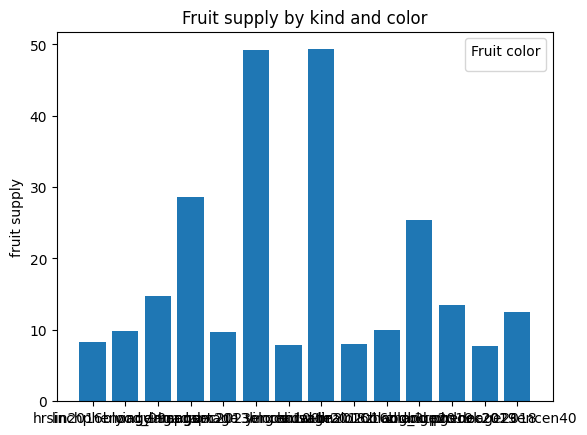

In [6]:
medaes = []
r2s = []
for mymodel in modelsnames:
    try:
        medae, r2 = medae_r2(data, y, LinearMethylationModel(mymodel, imputation='average'))
    except Exception:
        print(Exception)
        medae, r2 = None, None 
    medaes.append(medae)
    r2s.append(r2)       




In [8]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

In [19]:
# modelsnames.index('horvath2018')
# modelsnames.pop(7)
# medaes.pop(7)

49.32305736116612

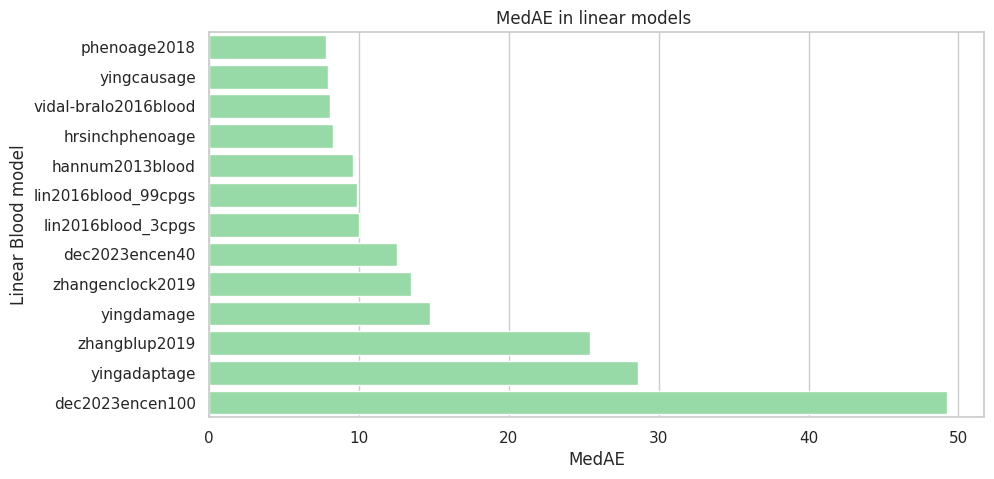

In [32]:
color = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize = (10, 5))
#plt.figure(figsize = (10, 5))
dfplot = pd.DataFrame({"modelsnames": modelsnames,
                   "medaes": medaes})
# Plot the total crashes
sns.set_color_codes("pastel")
dfplot = dfplot.sort_values('medaes')
sns.barplot(data=dfplot,x = 'medaes', y='modelsnames', color = 'g')


# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
#sns.despine(left=True, bottom=True)


ax.set_xlabel('MedAE')
ax.set_ylabel('Linear Blood model')
ax.set_title('MedAE in linear models ')
#ax.legend(title='linear model')

plt.show()

In [30]:
dfplot.sort_values('medaes')

,modelsnames,medaes
11,phenoage2018,7.794025
6,yingcausage,7.925758
7,vidal-bralo2016blood,8.070110
0,hrsinchphenoage,8.243389
4,hannum2013blood,9.628711
1,lin2016blood_99cpgs,9.883102
8,lin2016blood_3cpgs,9.974336
12,dec2023encen40,12.532515
10,zhangenclock2019,13.455650
2,yingdamage,14.742518
